In [1]:
import numpy as np
import matplotlib.pyplot as plt # plot
import pandas as pd
from scipy.integrate import solve_ivp  # to solve ODE system
from scipy.integrate import simps # calculate the yield with Simpson rule
from numpy import trapz # calculate the yield with trapezoid rule
from SALib.sample.morris import sample as ee_sample # sensitivity analysis
from SALib.analyze.morris import analyze as ee_analyze # sensitivity analysis
from tqdm import tqdm
from scipy.special import logsumexp # deal with NaN
import seaborn as sns # colourful plot

In [2]:
seed = 1234
method = "Radau"

In [3]:
tmax = 500
step = tmax*10
time_list = np.linspace(0, tmax, step)
num_of_points = 100

# Stage-structured Model Egg

## Parameter values

r=0.7
K=10
aL=0.18
hL=2
KBt=190
f=2
nE=1
alpha=0.08
aE=0.5 # 0<aE<1
c=1
qL=0.015
nL=0.01
mBt=1
mM=0.05
mA=0.5
BC=0
sig=2
bound=20 # economic threshold

In [4]:
r=0.7
K=10
aL=0.18
hL=2
KBt=190
f=2
nE=1
alpha=0.06
aE=0.5 # 0<aE<1
c=1
qL=0.01
nL=0.01
mBt=0.04
mM=0.1
mA=0.3
BC=0
sig=2
bound=20 # economic threshold

In [5]:
def ddf(t,sig_1,value_1,bound_1): #(t,sig,M,bound)
    val = 0.0
    if value_1>bound_1:
        t_transition=0.1
        half_life_time=1e5
        decay_constant = np.log(2)/half_life_time
        val = sig_1 * np.exp(-decay_constant * (t - t_transition))
    return val
inoculative_function = ddf

In [6]:
def structured_parasitism_model(
    t,
    X,
    r=r,
    K=K,
    aL=aL,
    hL=hL,
    KBt=KBt,
    f=f,
    nE=nE,
    alpha=alpha,
    aE=aE,
    c=c,
    qL=qL,
    nL=nL,
    mBt=mBt,
    mM=mM,
    mA=mA,
    BC=BC,
    BC_function=inoculative_function,
    sig=sig,
    bound=bound,
):
    R,RBt,E,EBt,L,LBt,M,A = X
#    R: resource (maize)
#    RBt: resource (maize) genetically modified Bt
#    E: egg pest
#    EBt: egg pest in Bt
#    L: larvae pest in R
#    LBt: larvae pest in RBt
#    M: adult moth pest
#    A: parasitoid of egg (biocontrol agent)
    R_prime=r*R*(1-R/K)-aL*R*M/(1+hL*R)
    RBt_prime=r*RBt*(1-RBt/KBt)-aL*RBt*M/(1+hL*RBt)
    E_prime=(K/(K+KBt))*f*M-nE*E-alpha*(E**aE)*A
    EBt_prime=(KBt/(K+KBt))*f*M-nE*EBt-alpha*(EBt**aE)*A
    L_prime=c*E*R*M/(1+hL*R)-qL*L**2-nL*L
    LBt_prime=c*EBt*RBt*M/(1+hL*RBt)-qL*LBt**2-mBt*LBt-nL*LBt
    M_prime=nL*(L+LBt)-mM*M
    BC=BC_function(t,sig,M,bound)
    A_prime=alpha*(E**aE+EBt**aE)*A-mA*A+BC
    return np.nan_to_num(R_prime),np.nan_to_num(RBt_prime),np.nan_to_num(E_prime),np.nan_to_num(EBt_prime),np.nan_to_num(L_prime),np.nan_to_num(LBt_prime),np.nan_to_num(M_prime),np.nan_to_num(A_prime)

def structured_parasitism_ode_solver(
    y0,
    t_span,
    t_eval,
    r=r,
    K=K,
    aL=aL,
    hL=hL,
    KBt=KBt,
    f=f,
    nE=nE,
    alpha=alpha,
    aE=aE,
    c=c,
    qL=qL,
    nL=nL,
    mBt=mBt,
    mM=mM,
    mA=mA,
    BC=BC,
    BC_function=inoculative_function,
    sig=sig,
    bound=bound,
):
    solution_ODE_structured_parasitism = solve_ivp(
        fun=structured_parasitism_model,
        t_span=t_span,
        y0=y0,
        t_eval=t_eval,
        args=(r,K,aL,hL,KBt,f,nE,alpha,aE,c,qL,nL,mBt,mM,mA),
        method=method,
    )
    return np.nan_to_num(solution_ODE_structured_parasitism)

t0 = time_list.min()
tf = time_list.max()
days_to_forecast = 0

In [7]:
# Initial conditions
y0 = np.array([10, 50, 0, 0, 0, 0, 5, 0]) # R, RBt, E, EBt, L, LBt, M, A

solution_ODE_structured_parasitism = structured_parasitism_ode_solver(y0,(t0, tf + days_to_forecast),time_list,r=r,K=K,aL=aL,hL=hL,KBt=KBt,mBt=mBt,f=f,nE=nE,alpha=alpha,aE=aE,mA=mA,c=c,qL=qL,nL=nL,mM=mM)
t_computed_structured_parasitism, y_computed_structured_parasitism = solution_ODE_structured_parasitism.t, solution_ODE_structured_parasitism.y
R,RBt,E,EBt,L,LBt,M,A = y_computed_structured_parasitism

<ipython-input-6-e4e2f75d633e>:35: RuntimeWarning: invalid value encountered in double_scalars
  E_prime=(K/(K+KBt))*f*M-nE*E-alpha*(E**aE)*A
<ipython-input-6-e4e2f75d633e>:41: RuntimeWarning: invalid value encountered in double_scalars
  A_prime=alpha*(E**aE+EBt**aE)*A-mA*A+BC
<ipython-input-6-e4e2f75d633e>:36: RuntimeWarning: invalid value encountered in double_scalars
  EBt_prime=(KBt/(K+KBt))*f*M-nE*EBt-alpha*(EBt**aE)*A


In [8]:
print(R[-1], RBt[-1], E[-1], EBt[-1], L[-1], LBt[-1], M[-1], A[-1])

8.27604263781755 188.4790017766144 0.5072255066991308 18.33074254704581 16.281281253434305 101.23586779861591 11.764473299733558 15.659197200260655


In [9]:
print(trapz(R),simps(R))

41393.96519431398 41393.96175967769


<ipython-input-10-f2f28840e2cd>:9: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


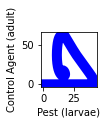

In [10]:
fig, ax = plt.subplots(figsize=(1, 1))

ax.plot(L, A, linestyle="-", linewidth=10, markersize=12,color="b")

plt.xlabel("Pest (larvae)")
plt.ylabel("Control Agent (adult)")
plt.rcParams.update({'font.size': 30})

plt.tight_layout()
plt.show()

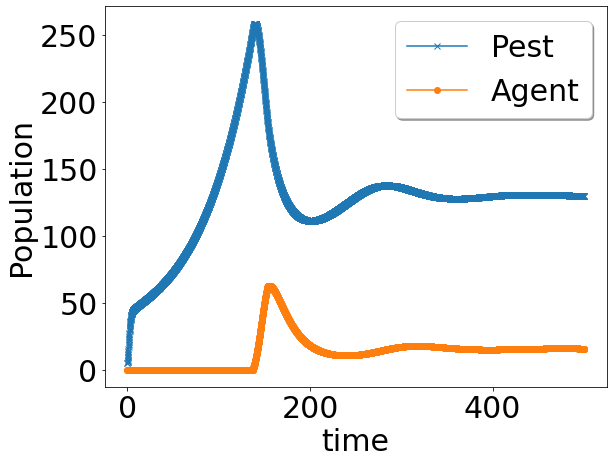

In [11]:
plt.figure(figsize=(9, 7))

plt.plot(time_list, E+L+LBt+M, '-x', label='Pest')
plt.plot(time_list, A, '-o', label='Agent')

plt.xlabel('time')
plt.ylabel('Population')

plt.legend(shadow=True)

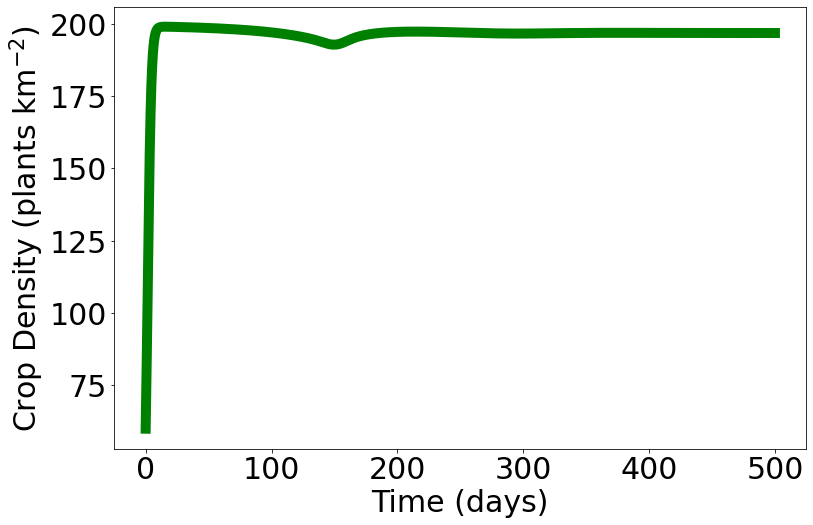

In [12]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(time_list, R+RBt, linestyle="-", linewidth=10, color="g") #label="Resource",

plt.xlabel("Time (days)")
plt.ylabel("Crop Density (plants $\mathregular{km^{-2}}$)")
plt.rcParams.update({'font.size': 30})

#plt.ylim([0, 1])

plt.savefig('img/structured_parasitism_resource.png', format='png')
plt.tight_layout()
plt.show()

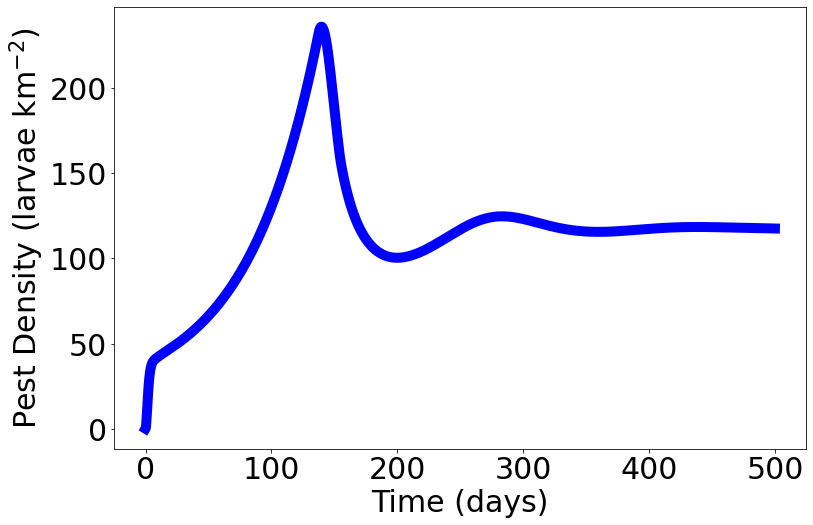

In [13]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(time_list, L+LBt, linestyle="-", linewidth=10, markersize=12,color="b") #, label="Pest"

plt.xlabel("Time (days)")
plt.ylabel("Pest Density (larvae $\mathregular{km^{-2}}$)")
plt.rcParams.update({'font.size': 30})

#plt.ylim([0, 1])

plt.savefig('img/structured_parasitism_pest.png', format='png', bbox_inches = 'tight')
plt.tight_layout()
plt.show()

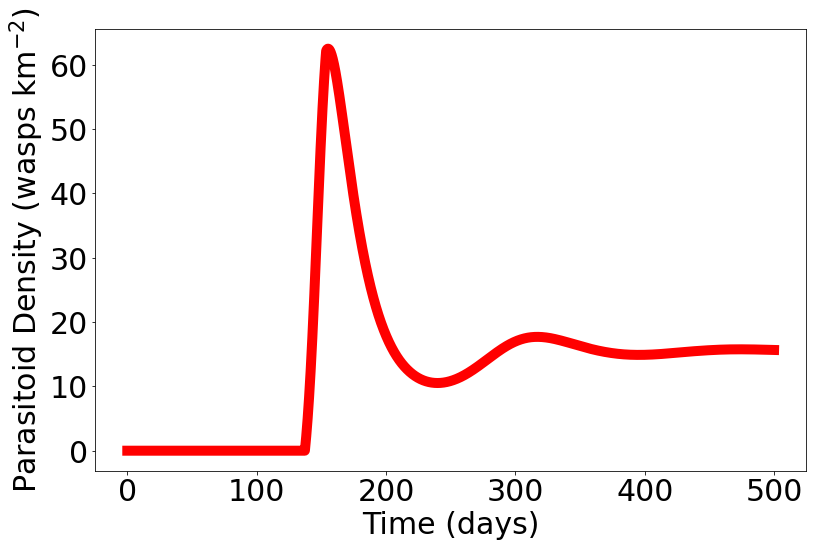

In [14]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(time_list, A, linestyle="-", linewidth=10, markersize=12,color="r") #, label="Control Agent"

plt.xlabel("Time (days)")
plt.ylabel("Parasitoid Density (wasps $\mathregular{km^{-2}}$)")
plt.rcParams.update({'font.size': 30})

#plt.ylim([0, 1])

plt.savefig('img/structured_parasitism_agent.png', format='png', bbox_inches = 'tight')
plt.tight_layout()
plt.show()

## Sensitivity Analyses

### Pest population

In [15]:
mean_values_params = [
    r,
    K,
    aL,
    hL,
    KBt,
    f,
    nE,
    alpha,
    aE,
    c,
    qL,
    nL,
    mBt,
    mM,
    mA,
]
factors_names = [
    r"$r$",
    r"$K$",
    r"$\mathregular{a_L}$",
    r"$\mathregular{h_L}$",
    r"$\mathregular{K_{Bt}}$",
    r"$f$",
    r"$\mathregular{n_E}$",
    r"$\mathregular{\alpha}$",
    r"$\mathregular{a_E}$",
    r"$c$",
    r"$\mathregular{q_L}$",
    r"$\mathregular{n_L}$",
    r"$\mathregular{m_{Bt}}$",
    r"$\mathregular{m_M}$",
    r"$\mathregular{m_A}$",
]
params_perturbations = 0.1
problem_info = {
    'num_vars': len(mean_values_params),
    'names': factors_names,
    'bounds': [[param - params_perturbations * param, param + params_perturbations * param] for param in mean_values_params]
}

grid_level = 4
num_of_trajectories = 20
parameter_values = ee_sample(problem_info, grid_level, num_of_trajectories, local_optimization=False, seed=seed)

In [16]:
t0 = time_list.min()
tf = time_list.max()
days_to_forecast = 0
time_list_range = np.linspace(t0, tf + days_to_forecast, 100)

num_of_realizations = parameter_values.shape[0]
num_of_time_list_points = time_list_range.shape[0]
qoi_sensitivity_outputs = np.zeros([num_of_realizations, num_of_time_list_points])

for realization_index, parameterL_realization in tqdm(enumerate(parameter_values), total=len(parameter_values)):
    
    realization_ODE_structured_parasitism = structured_parasitism_ode_solver(
        y0, 
        (t0, tf + days_to_forecast), 
        time_list_range, 
        *parameterL_realization
    )
    R_realization,RBt_realization,E_realization,EBt_realization,L_realization,LBt_realization,M_realization,A_realization = realization_ODE_structured_parasitism.y
    
    qoi_sensitivity_outputs[realization_index, :] = (R_realization + RBt_realization)

  2%|▏         | 1/64 [00:00<00:09,  6.52it/s]<ipython-input-6-e4e2f75d633e>:35: RuntimeWarning: invalid value encountered in double_scalars
  E_prime=(K/(K+KBt))*f*M-nE*E-alpha*(E**aE)*A
<ipython-input-6-e4e2f75d633e>:41: RuntimeWarning: invalid value encountered in double_scalars
  A_prime=alpha*(E**aE+EBt**aE)*A-mA*A+BC
<ipython-input-6-e4e2f75d633e>:36: RuntimeWarning: invalid value encountered in double_scalars
  EBt_prime=(KBt/(K+KBt))*f*M-nE*EBt-alpha*(EBt**aE)*A
100%|██████████| 64/64 [00:06<00:00, 10.31it/s]


In [17]:
df_Si = pd.DataFrame(columns=['time_list', *problem_info['names']])
df_sigmai = pd.DataFrame(columns=['time_list', *problem_info['names']])
df_Si['time_list'] = time_list_range
df_sigmai['time_list'] = time_list_range
for time_list_point in tqdm(range(num_of_time_list_points)):
    try:
        Si = ee_analyze(
            problem_info, 
            parameter_values, 
            qoi_sensitivity_outputs[:, time_list_point], 
            num_levels=grid_level, 
            seed=seed
        )
        Si['mu_star_normalized'] = Si['mu_star'] / Si['mu_star'].sum()
        sigmai_normalized = Si['sigma'] / Si['sigma'].sum()
        for idx, param_name in enumerate(problem_info['names']):
            df_Si.loc[time_list_point, param_name] = Si['mu_star_normalized'][idx]
            df_sigmai.loc[time_list_point, param_name] = sigmai_normalized[idx]
    except:
        continue

df_Si.sort_values(by='time_list', inplace=True)
df_Si.drop(index=0, inplace=True)
df_Si.dropna(inplace=True)
df_Si.reset_index(drop=True, inplace=True)

df_sigmai.sort_values(by='time_list', inplace=True)
df_sigmai.drop(index=0, inplace=True)
df_sigmai.dropna(inplace=True)
df_sigmai.reset_index(drop=True, inplace=True)

valid_time_lists = df_Si.time_list.values
df_Si

  0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-17-e2364e699021>:15: RuntimeWarning: invalid value encountered in true_divide
  sigmai_normalized = Si['sigma'] / Si['sigma'].sum()
100%|██████████| 100/100 [00:00<00:00, 188.65it/s]


,time_list,$r$,$K$,$\mathregular{a_L}$,$\mathregular{h_L}$,$\mathregular{K_{Bt}}$,$f$,$\mathregular{n_E}$,$\mathregular{\alpha}$,$\mathregular{a_E}$,$c$,$\mathregular{q_L}$,$\mathregular{n_L}$,$\mathregular{m_{Bt}}$,$\mathregular{m_M}$,$\mathregular{m_A}$
0,5.050505,0.229319,0.043646,0.00615713,0.00643231,0.709987,0.000554583,0.000513171,0,0,0.000569543,0.000121415,0.000710642,2.6487e-05,0.0019624,0
1,10.101010,0.0221175,0.0477456,0.00504363,0.00675065,0.905711,0.00183294,0.00167232,0,0,0.00169123,0.00101109,0.00246723,0.000108633,0.0038485,0
2,15.151515,0.00570206,0.0477788,0.0050047,0.00760989,0.913887,0.00322746,0.00221077,0,0,0.0028244,0.00147061,0.00433247,0.000196124,0.00575535,0
3,20.202020,0.00484396,0.0471017,0.00506468,0.00897597,0.90537,0.00459829,0.00361506,0,0,0.00394761,0.00230231,0.00622072,0.000286877,0.00767284,0
4,25.252525,0.0047851,0.0464019,0.00517766,0.0104212,0.896099,0.00614696,0.0047549,0,0,0.00507704,0.00316407,0.00812129,0.000374896,0.00947567,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,479.797980,0.0382441,0.0466693,0.00416881,0.0668305,0.53631,0.0196961,0.0141545,0.00370735,0.0087582,0.0842235,0.0237158,0.0820664,0.00740316,0.0587261,0.00532638
95,484.848485,0.0384132,0.0438095,0.00425926,0.064246,0.540876,0.019556,0.0142476,0.00374166,0.00887031,0.0864384,0.0231016,0.081165,0.00773263,0.0580894,0.00545393
96,489.898990,0.0385852,0.0409905,0.00434948,0.0617492,0.545536,0.0193945,0.0142949,0.00377589,0.00896699,0.0884816,0.0226609,0.0801685,0.0080778,0.0573836,0.00558484
97,494.949495,0.0387393,0.038483,0.0044352,0.0595962,0.549961,0.0191879,0.0142906,0.00380783,0.00904088,0.0903749,0.0223507,0.0790183,0.00843513,0.0565631,0.00571572


In [18]:
df_sigmai

,time_list,$r$,$K$,$\mathregular{a_L}$,$\mathregular{h_L}$,$\mathregular{K_{Bt}}$,$f$,$\mathregular{n_E}$,$\mathregular{\alpha}$,$\mathregular{a_E}$,$c$,$\mathregular{q_L}$,$\mathregular{n_L}$,$\mathregular{m_{Bt}}$,$\mathregular{m_M}$,$\mathregular{m_A}$
0,5.050505,0.479975,0.00629155,0.0103239,0.0127661,0.480566,0.00243348,0.00178891,0,0,0.00146143,0.000371071,0.00178366,5.83451e-05,0.00218005,0
1,10.101010,0.262757,0.00659565,0.0934803,0.0702114,0.278551,0.0476183,0.0703317,0,0,0.0278845,0.0509667,0.0464315,0.00244605,0.0427258,0
2,15.151515,0.0918382,0.0102104,0.132859,0.193388,0.0176868,0.116833,0.126295,0,0,0.0530033,0.0498371,0.105075,0.00618769,0.0967873,0
3,20.202020,0.0753044,0.0114351,0.108373,0.201604,0.00479233,0.133797,0.131402,0,0,0.0525349,0.0644832,0.111738,0.0066521,0.0978843,0
4,25.252525,0.0640473,0.012588,0.0903088,0.20861,0.00543746,0.145175,0.133283,0,0,0.0514316,0.0712951,0.112912,0.00668458,0.0982268,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,479.797980,0.124748,0.0597013,0.00767464,0.168175,0.00171534,0.0471027,0.0176326,0.0121039,0.0181271,0.180932,0.0485925,0.159251,0.0233918,0.113463,0.0173898
95,484.848485,0.127083,0.0502304,0.00803766,0.166261,0.00172137,0.0496735,0.0181207,0.0123881,0.0186496,0.18407,0.0471722,0.160451,0.0248403,0.113244,0.0180572
96,489.898990,0.12931,0.0405572,0.00839809,0.164694,0.00172843,0.0523413,0.0186106,0.0126623,0.0191138,0.187174,0.0462175,0.161374,0.0263498,0.112741,0.0187285
97,494.949495,0.131241,0.0316679,0.00873724,0.163678,0.00173392,0.0550045,0.0190786,0.0129072,0.0194824,0.190058,0.0455851,0.161783,0.0278822,0.111787,0.0193742


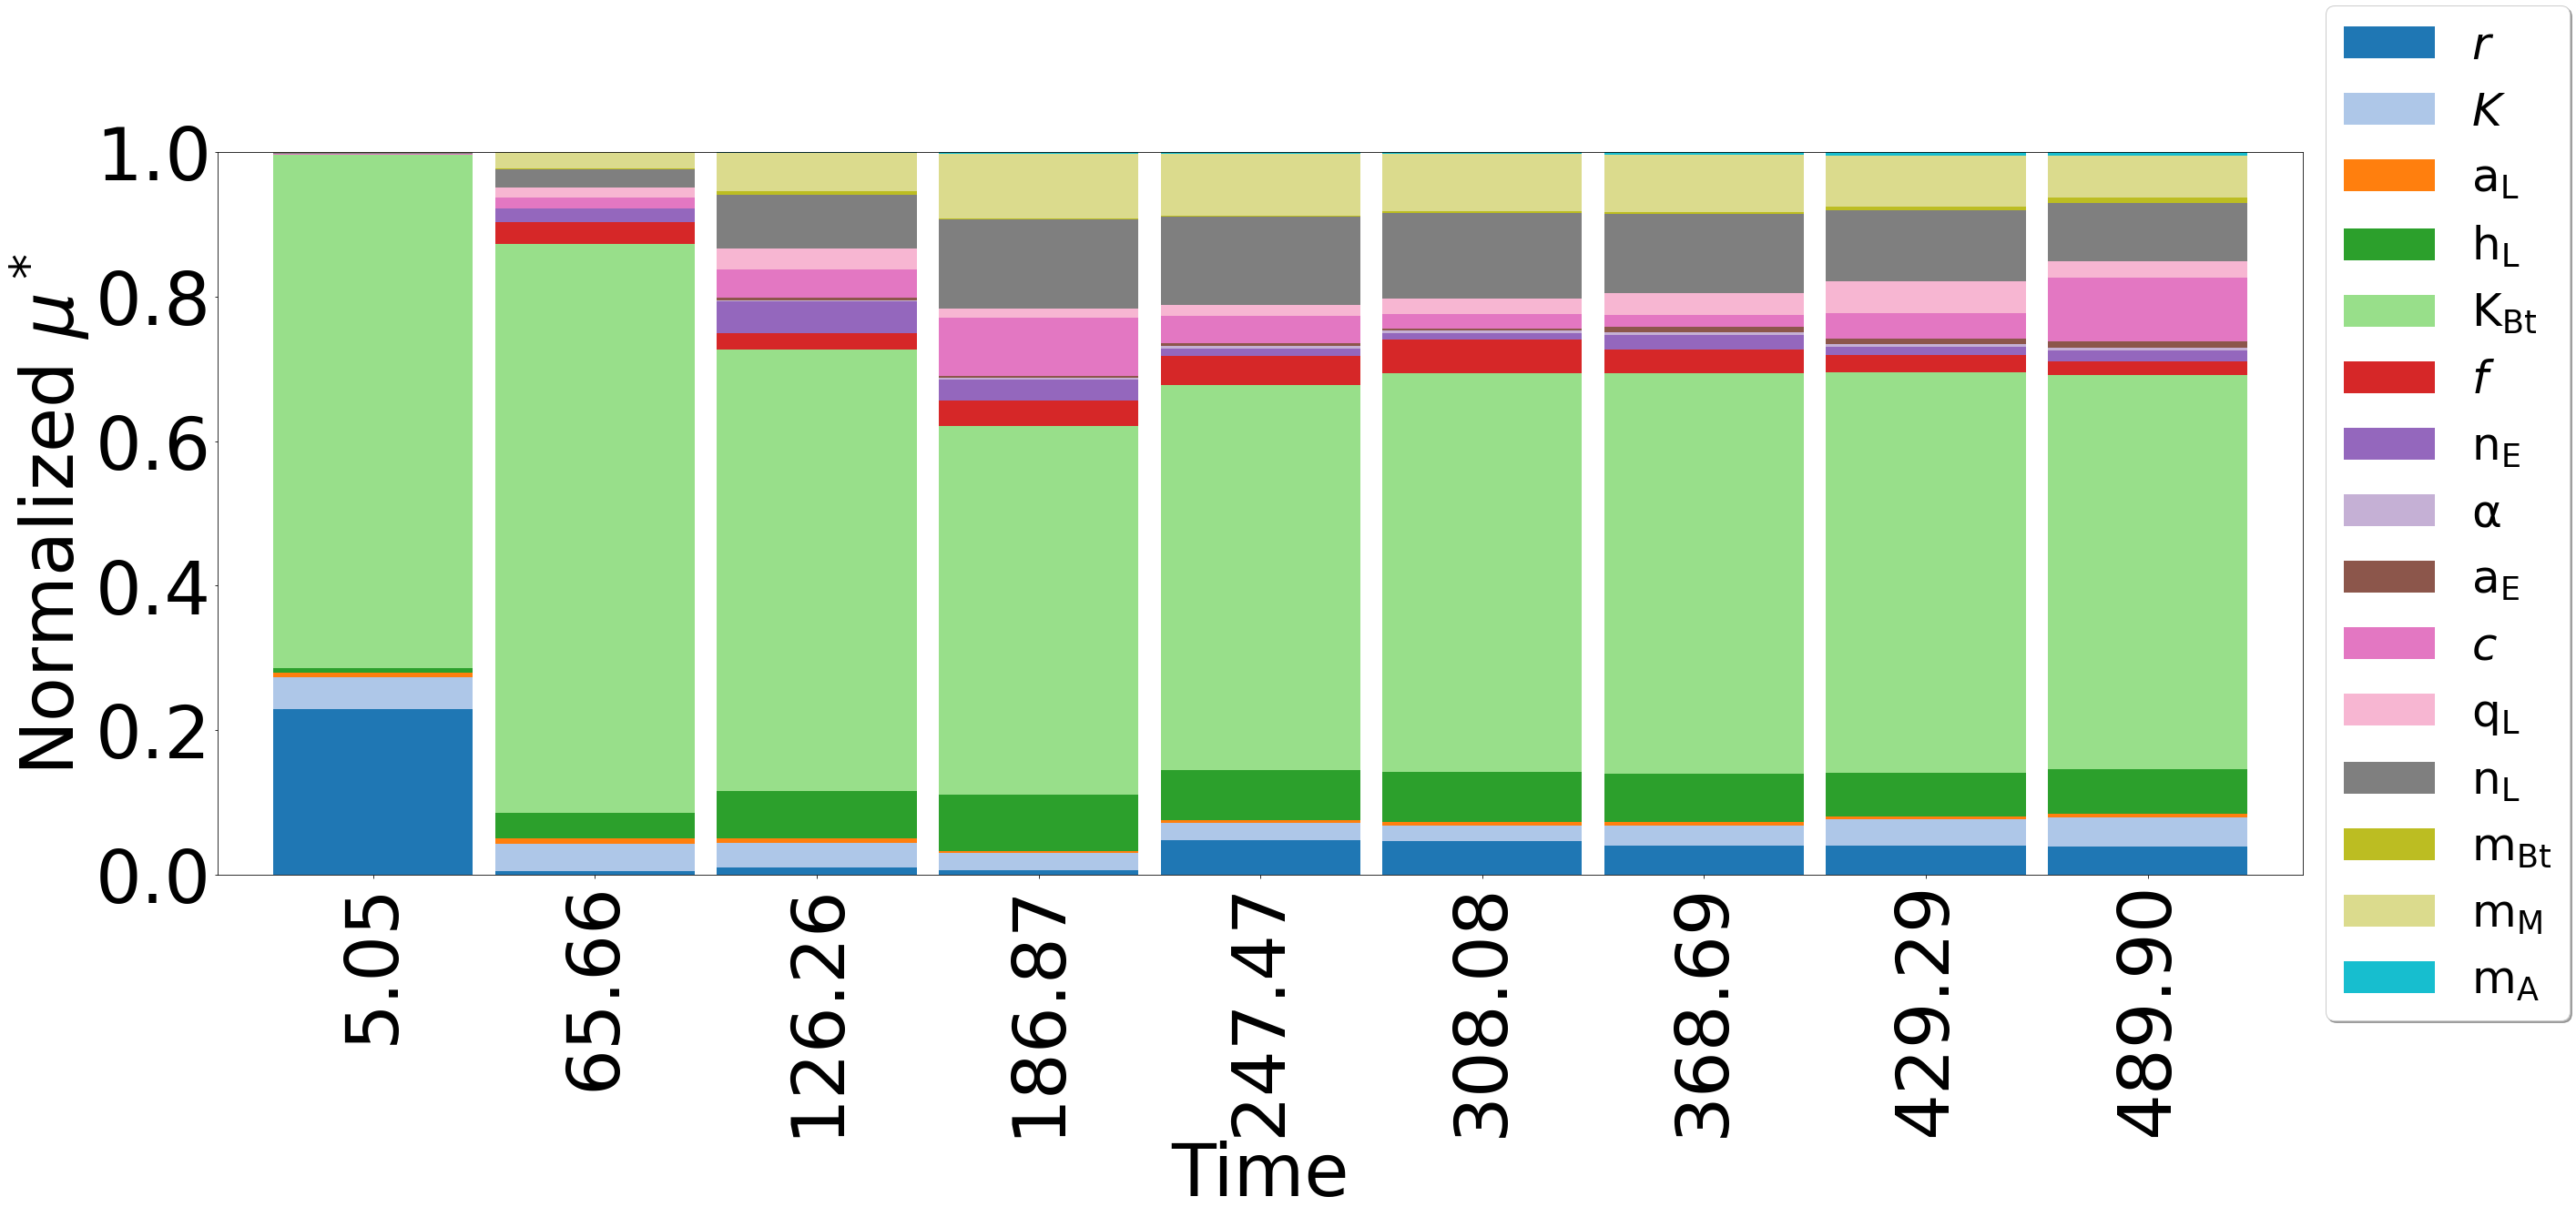

In [19]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 12
valid_time_lists_to_plot_mu = valid_time_lists[::step_to_plot]

#colors = sns.color_palette("coolwarm",16)
colors =  plt.cm.tab20( (4./3*np.arange(20*3/4)).astype(int) )
ax.set_prop_cycle('color', colors)

df_Si[::step_to_plot].plot.bar(x='time_list', rot=90, width=0.9, figsize=(40, 18), stacked=True, ax=ax, color=colors)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_time_lists_to_plot_mu[x]:.2f}")
plt.xlabel("Time", fontsize = 80)
plt.ylabel(r"Normalized $\mu^*$", fontsize = 80)

plt.xticks(fontsize=80)
plt.yticks(fontsize=80)

plt.ylim([0, 1])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, fancybox=True, shadow=True, fontsize=50)

plt.tight_layout()
plt.savefig("img/SA_structured_parasitism_mu.png", format='png', bbox_inches = 'tight', dpi=50)
plt.show()

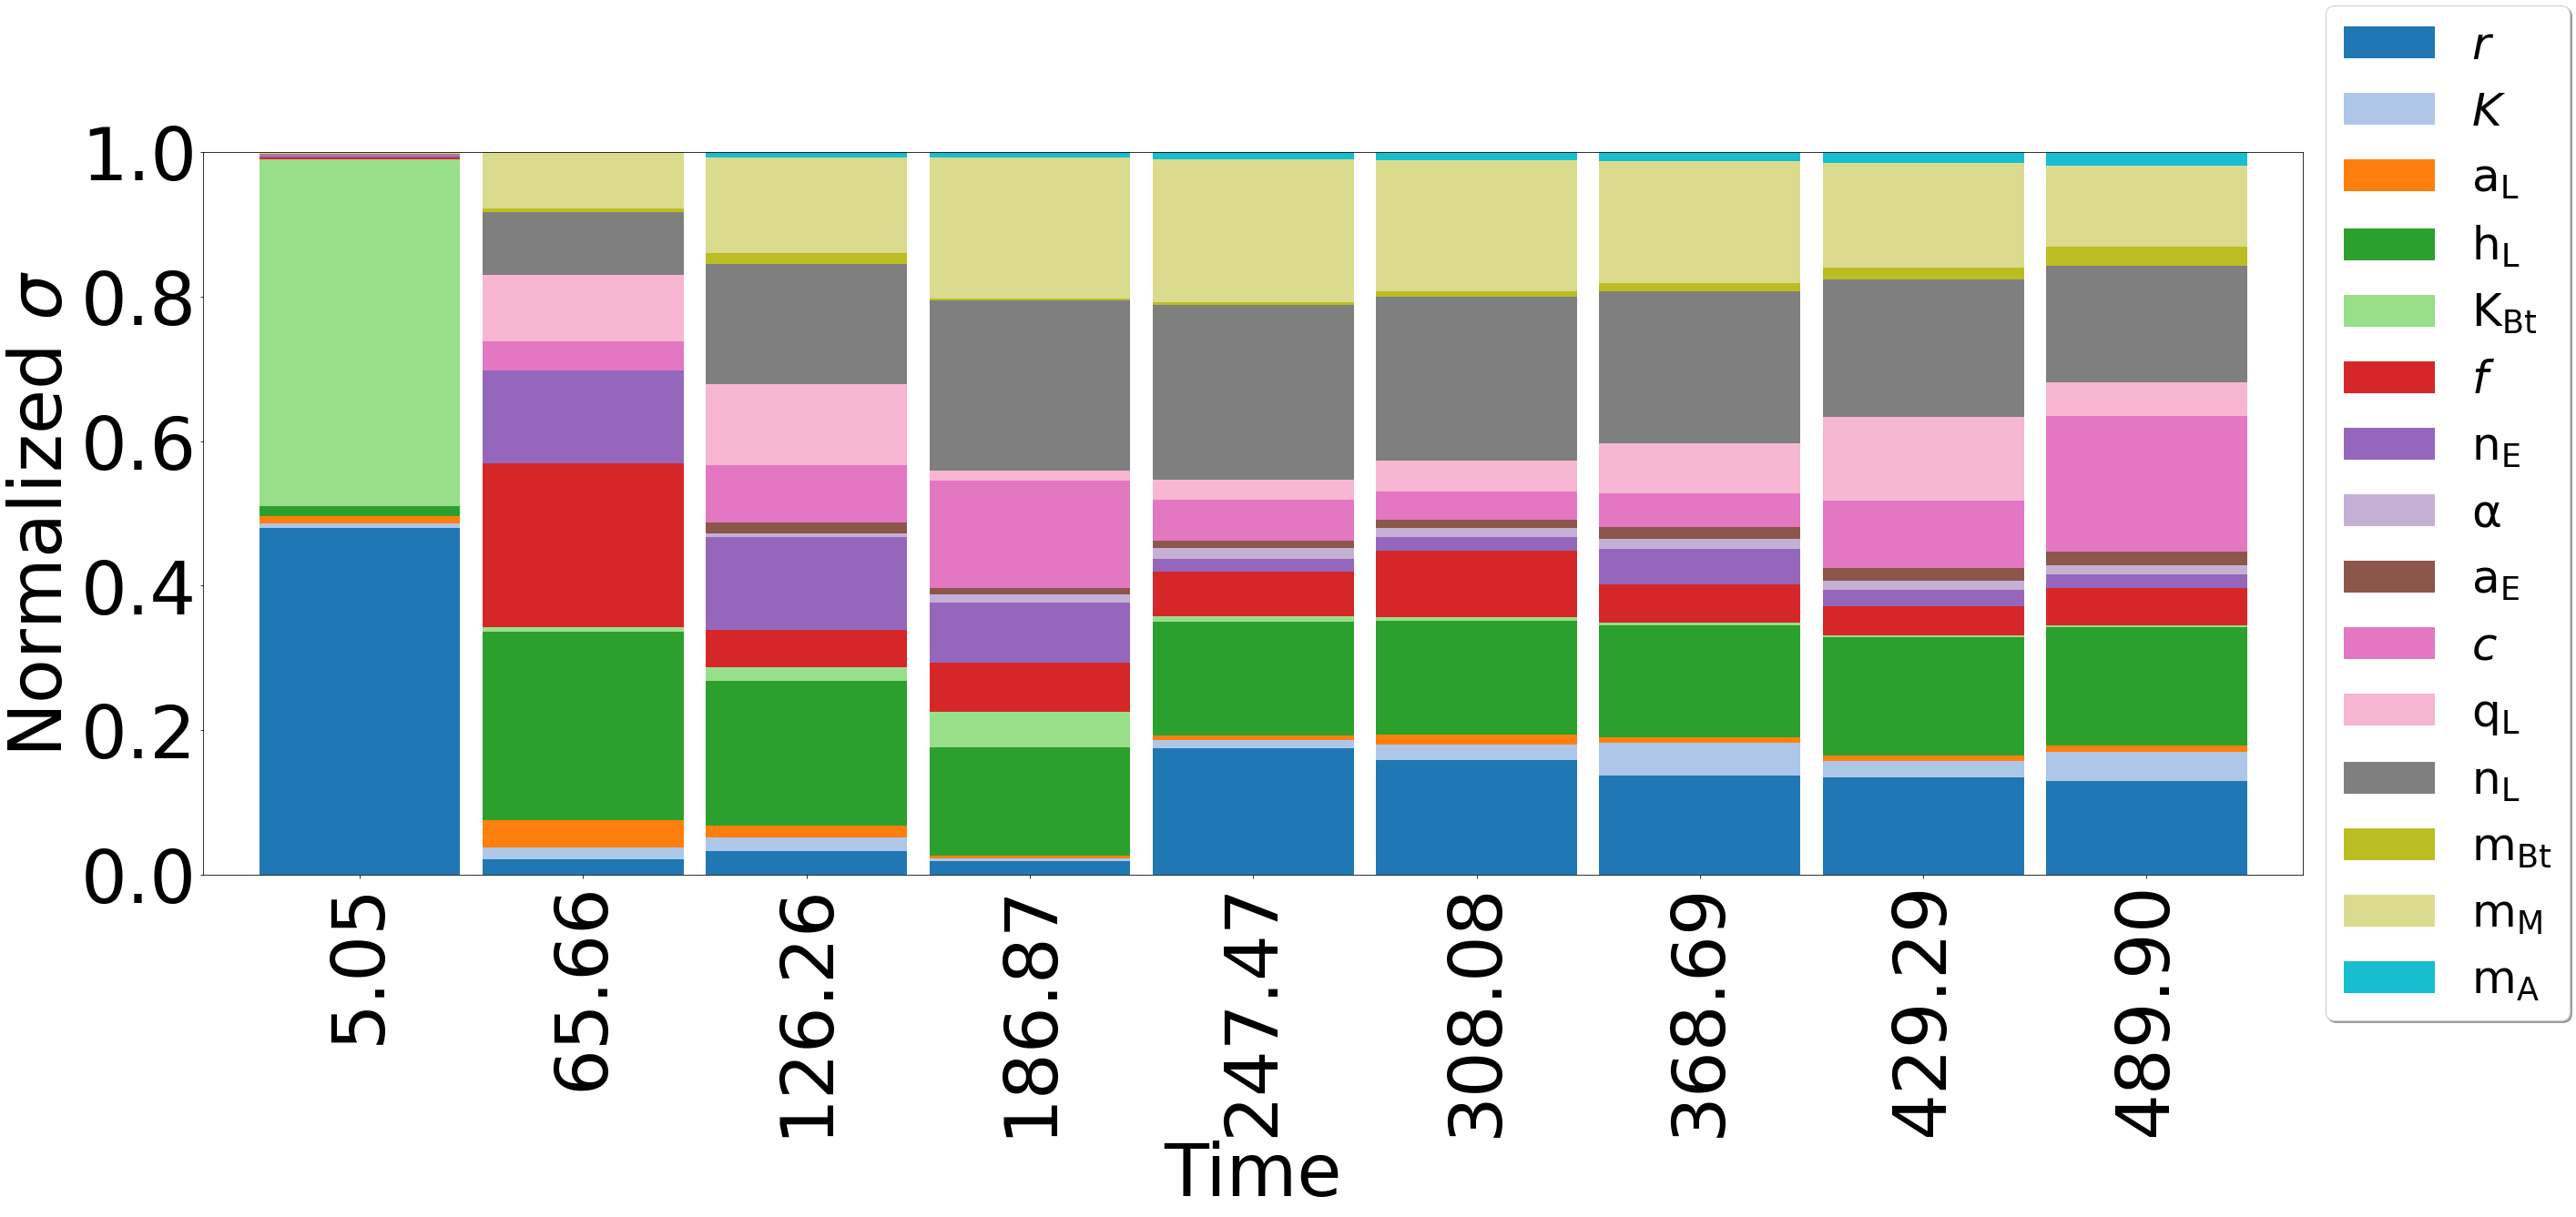

In [20]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 12
valid_time_lists_to_plot_sigma = valid_time_lists[::step_to_plot]

#colors = sns.color_palette("coolwarm",16)
colors =  plt.cm.tab20( (4./3*np.arange(20*3/4)).astype(int) )
ax.set_prop_cycle('color', colors)

df_sigmai[::step_to_plot].plot.bar(x='time_list', rot=90, width=0.9, figsize=(40, 18), stacked=True, ax=ax, color=colors)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_time_lists_to_plot_sigma[x]:.2f}")
plt.xlabel("Time", fontsize = 80)
plt.ylabel(r"Normalized $\sigma$", fontsize = 80)

plt.xticks(fontsize=80)
plt.yticks(fontsize=80)

plt.ylim([0, 1])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, fancybox=True, shadow=True, fontsize=50)

plt.tight_layout()
plt.savefig("img/SA_structured_parasitism_sigma.png", format='png', bbox_inches = 'tight', dpi=50)
plt.show()

# Continuation diagram

In [21]:
plt.rcParams.update({'font.size': 8})

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rcParams['lines.linewidth'] = BIGGER_SIZE
plt.rcParams.update({'font.size': BIGGER_SIZE})

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

Running continuation:   0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-6-e4e2f75d633e>:35: RuntimeWarning: invalid value encountered in double_scalars
  E_prime=(K/(K+KBt))*f*M-nE*E-alpha*(E**aE)*A
<ipython-input-6-e4e2f75d633e>:41: RuntimeWarning: invalid value encountered in double_scalars
  A_prime=alpha*(E**aE+EBt**aE)*A-mA*A+BC
Running continuation:   2%|▏         | 2/100 [00:00<00:15,  6.33it/s]<ipython-input-6-e4e2f75d633e>:36: RuntimeWarning: invalid value encountered in double_scalars
  EBt_prime=(KBt/(K+KBt))*f*M-nE*EBt-alpha*(EBt**aE)*A
Plotting results: 100%|██████████| 8/8 [00:00<00:00, 124.62it/s]
<ipython-input-22-28dfd8ad1112>:129: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


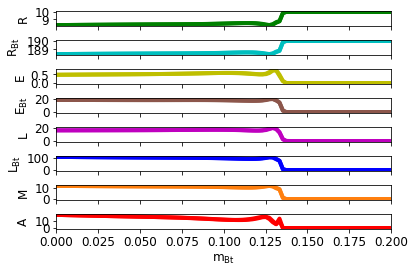

In [22]:
def run_continuation_analysis(
    ode_solver_wrapper,
    continuation_variable_name,
    parameter_span,
    parameter_num_of_points,
    fixed_parameters_dict,
    initial_conditions,
    output_variable_name_list,
    num_of_last_outcomes,
):
    if type(continuation_variable_name) != str:
        raise ValueError("Input continuation_variable_name must be of str type.")

    if type(parameter_num_of_points) != int:
        raise ValueError("Input parameter_num_of_points must be of integer type.")

    parameter_span_type = type(parameter_span)
    if parameter_span_type != tuple and parameter_span_type != list:
        raise ValueError("Input parameter_span must be a list or tuple of values.")
    else:
        if len(parameter_span) != 2:
            raise ValueError("Input parameter_span must be a list or tuple with two values.")

    if len(initial_conditions) != len(output_variable_name_list):
        raise ValueError(
            "The number of output variables from ODE model must be equal to number of initial conditions."
        )

    parameter_values = np.linspace(parameter_span[0], parameter_span[1], parameter_num_of_points)
    continuation_parameter_values_dict = {continuation_variable_name: parameter_values}
    time_values = time_list

    # Creating dictionary to record continuation realizations
    output_variables_dict = dict()
    for output_variable_name in output_variable_name_list:
        output_variables_dict[output_variable_name] = list()

    # Running continuation evaluations
    parameter_progress_bar = tqdm(parameter_values)
    for parameter_value in parameter_progress_bar:
        parameter_progress_bar.set_description("Running continuation")
        parameters = fixed_parameters
        parameters[continuation_variable_name] = parameter_value
        ode_solver_output = ode_solver_wrapper(initial_conditions, (t0, tf + days_to_forecast), time_values, **parameters)
        t_output, y_output = ode_solver_output.t, ode_solver_output.y
        y_last_outputs = y_output[:, -num_of_last_outcomes:]
        output_index = 0
        for output_variable_name in output_variable_name_list:
            output_variable_last_results = y_last_outputs[output_index]
            output_variables_dict[output_variable_name].append(
                [output_variable_last_results.min(), output_variable_last_results.max()]
            )
            output_index += 1

    return continuation_parameter_values_dict, output_variables_dict

fixed_parameters = {
    "r": r,
    "K": K,
    "aL": aL,
    "hL": hL,
    "KBt": KBt,
    "f": f,
    "nE": nE,
    "alpha": alpha,
    "aE": aE,
    "c": c,
    "qL": qL,
    "nL": nL,
#    "mBt": mBt,
    "mM": mM,
    "mA": mA,
}


mBt_min = 0.0
mBt_max = 0.2
mBt_points = np.linspace(mBt_min, mBt_max, num_of_points)
parameter_to_continuation = {"mBt": mBt_points}

mBt_values, y_last_results = run_continuation_analysis(
    ode_solver_wrapper=structured_parasitism_ode_solver,
    continuation_variable_name="mBt",
    parameter_span=(mBt_min, mBt_max),
    parameter_num_of_points=num_of_points,
    fixed_parameters_dict=fixed_parameters,
    initial_conditions=y0,
    output_variable_name_list=["R","$\mathregular{R_{Bt}}$","E","$\mathregular{E_{Bt}}$","L","$\mathregular{L_{Bt}}$","M","A"],
    num_of_last_outcomes=100,
)

colors_list = ["g","c","y","tab:brown","m","b","tab:orange","r"]
results_progress_bar = tqdm(y_last_results)
num_of_state_variables = len(y_last_results)
fig, axs = plt.subplots(num_of_state_variables, sharex=True, gridspec_kw={"hspace": 1})
index = 0
for variable_name in results_progress_bar:
    results_progress_bar.set_description("Plotting results")
    variable_result = np.array(y_last_results[variable_name])
    variable_min_values = variable_result[:, 0].astype(np.int)
    variable_max_values = variable_result[:, 1].astype(np.int)

    color = colors_list[index]
    axs[index].plot(
        mBt_values["mBt"], variable_result, color=color, alpha=1, linewidth=4
    )

    index += 1

for ax, variable_name in zip(axs.flat, y_last_results):
    ax.set(xlabel=r"$\mathregular{m_{Bt}}$", ylabel=f"{variable_name}", xlim=(mBt_min, mBt_max))
    ax.plot(linewidth=15, markersize=20)
    ax.label_outer()

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rcParams['lines.linewidth'] = BIGGER_SIZE
plt.rcParams.update({'font.size': BIGGER_SIZE})

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.tight_layout()
#plt.savefig("img/continuation_mBt.png", format='png', bbox_inches = "tight", dpi=300)

Running continuation:  30%|███       | 30/100 [00:05<00:18,  3.86it/s]<ipython-input-6-e4e2f75d633e>:35: RuntimeWarning: invalid value encountered in double_scalars
  E_prime=(K/(K+KBt))*f*M-nE*E-alpha*(E**aE)*A
<ipython-input-6-e4e2f75d633e>:41: RuntimeWarning: invalid value encountered in double_scalars
  A_prime=alpha*(E**aE+EBt**aE)*A-mA*A+BC
Running continuation:  32%|███▏      | 32/100 [00:06<00:17,  3.84it/s]<ipython-input-6-e4e2f75d633e>:36: RuntimeWarning: invalid value encountered in double_scalars
  EBt_prime=(KBt/(K+KBt))*f*M-nE*EBt-alpha*(EBt**aE)*A
Plotting results: 100%|██████████| 8/8 [00:00<00:00, 128.86it/s]
<ipython-input-23-0c6545d2bf43>:131: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


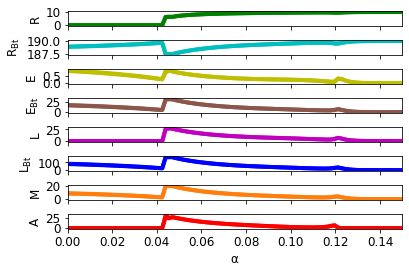

In [23]:
def run_continuation_analysis(
    ode_solver_wrapper,
    continuation_variable_name,
    parameter_span,
    parameter_num_of_points,
    fixed_parameters_dict,
    initial_conditions,
    output_variable_name_list,
    num_of_last_outcomes,
):
    if type(continuation_variable_name) != str:
        raise ValueError("Input continuation_variable_name must be of str type.")

    if type(parameter_num_of_points) != int:
        raise ValueError("Input parameter_num_of_points must be of integer type.")

    parameter_span_type = type(parameter_span)
    if parameter_span_type != tuple and parameter_span_type != list:
        raise ValueError("Input parameter_span must be a list or tuple of values.")
    else:
        if len(parameter_span) != 2:
            raise ValueError("Input parameter_span must be a list or tuple with two values.")

    if len(initial_conditions) != len(output_variable_name_list):
        raise ValueError(
            "The number of output variables from ODE model must be equal to number of initial conditions."
        )

    parameter_values = np.linspace(parameter_span[0], parameter_span[1], parameter_num_of_points)
    continuation_parameter_values_dict = {continuation_variable_name: parameter_values}
    time_values = time_list

    # Creating dictionary to record continuation realizations
    output_variables_dict = dict()
    for output_variable_name in output_variable_name_list:
        output_variables_dict[output_variable_name] = list()

    # Running continuation evaluations
    parameter_progress_bar = tqdm(parameter_values)
    for parameter_value in parameter_progress_bar:
        parameter_progress_bar.set_description("Running continuation")
        parameters = fixed_parameters
        parameters[continuation_variable_name] = parameter_value
        ode_solver_output = ode_solver_wrapper(initial_conditions, (t0, tf + days_to_forecast), time_values, **parameters)
        t_output, y_output = ode_solver_output.t, ode_solver_output.y
        y_last_outputs = y_output[:, -num_of_last_outcomes:]
        output_index = 0
        for output_variable_name in output_variable_name_list:
            output_variable_last_results = y_last_outputs[output_index]
            output_variables_dict[output_variable_name].append(
                [output_variable_last_results.min(), output_variable_last_results.max()]
            )
            output_index += 1

    return continuation_parameter_values_dict, output_variables_dict

fixed_parameters = {
    "r": r,
    "K": K,
    "aL": aL,
    "hL": hL,
    "KBt": KBt,
    "f": f,
    "nE": nE,
#    "alpha": alpha,
    "aE": aE,
    "c": c,
    "qL": qL,
    "nL": nL,
    "mBt": mBt,
    "mM": mM,
    "mA": mA,
}


alpha_min = 0.0
alpha_max = 0.15
alpha_points = np.linspace(alpha_min, alpha_max, num_of_points)
parameter_to_continuation = {"alpha": alpha_points}

alpha_values, y_last_results = run_continuation_analysis(
    ode_solver_wrapper=structured_parasitism_ode_solver,
    continuation_variable_name="alpha",
    parameter_span=(alpha_min, alpha_max),
    parameter_num_of_points=num_of_points,
    fixed_parameters_dict=fixed_parameters,
    initial_conditions=y0,
    output_variable_name_list=["R","$\mathregular{R_{Bt}}$","E","$\mathregular{E_{Bt}}$","L","$\mathregular{L_{Bt}}$","M","A"],
    num_of_last_outcomes=100,
)

colors_list = ["g","c","y","tab:brown","m","b","tab:orange","r"]
results_progress_bar = tqdm(y_last_results)
num_of_state_variables = len(y_last_results)
fig, axs = plt.subplots(num_of_state_variables, sharex=True, gridspec_kw={"hspace": 1})
index = 0
for variable_name in results_progress_bar:
    results_progress_bar.set_description("Plotting results")
    variable_result = np.array(y_last_results[variable_name])
    variable_min_values = variable_result[:, 0].astype(np.int)
    variable_max_values = variable_result[:, 1].astype(np.int)

    color = colors_list[index]
    axs[index].plot(
        alpha_values["alpha"], variable_result, color=color, alpha=1, linewidth=4
    )

    index += 1

for ax, variable_name in zip(axs.flat, y_last_results):
    ax.set(xlabel=r"$\mathregular{\alpha}$", ylabel=f"{variable_name}", xlim=(alpha_min, alpha_max))
    ax.plot(linewidth=15, markersize=20)
    ax.label_outer()

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rcParams['lines.linewidth'] = BIGGER_SIZE
plt.rcParams.update({'font.size': BIGGER_SIZE})

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig.subplots_adjust(hspace=0.3)

plt.tight_layout()
plt.savefig("img/continuation_alpha.png", format='png', bbox_inches = "tight", dpi=300)

In [ ]:
def run_continuation_analysis(
    ode_solver_wrapper,
    continuation_variable_name,
    parameter_span,
    parameter_num_of_points,
    fixed_parameters_dict,
    initial_conditions,
    output_variable_name_list,
    num_of_last_outcomes,
):
    if type(continuation_variable_name) != str:
        raise ValueError("Input continuation_variable_name must be of str type.")

    if type(parameter_num_of_points) != int:
        raise ValueError("Input parameter_num_of_points must be of integer type.")

    parameter_span_type = type(parameter_span)
    if parameter_span_type != tuple and parameter_span_type != list:
        raise ValueError("Input parameter_span must be a list or tuple of values.")
    else:
        if len(parameter_span) != 2:
            raise ValueError("Input parameter_span must be a list or tuple with two values.")

    if len(initial_conditions) != len(output_variable_name_list):
        raise ValueError(
            "The number of output variables from ODE model must be equal to number of initial conditions."
        )

    parameter_values = np.linspace(parameter_span[0], parameter_span[1], parameter_num_of_points)
    continuation_parameter_values_dict = {continuation_variable_name: parameter_values}
    time_values = time_list

    # Creating dictionary to record continuation realizations
    output_variables_dict = dict()
    for output_variable_name in output_variable_name_list:
        output_variables_dict[output_variable_name] = list()

    # Running continuation evaluations
    parameter_progress_bar = tqdm(parameter_values)
    for parameter_value in parameter_progress_bar:
        parameter_progress_bar.set_description("Running continuation")
        parameters = fixed_parameters
        parameters[continuation_variable_name] = parameter_value
        ode_solver_output = ode_solver_wrapper(initial_conditions, (t0, tf + days_to_forecast), time_values, **parameters)
        t_output, y_output = ode_solver_output.t, ode_solver_output.y
        y_last_outputs = y_output[:, -num_of_last_outcomes:]
        output_index = 0
        for output_variable_name in output_variable_name_list:
            output_variable_last_results = y_last_outputs[output_index]
            output_variables_dict[output_variable_name].append(
                [output_variable_last_results.min(), output_variable_last_results.max()]
            )
            output_index += 1

    return continuation_parameter_values_dict, output_variables_dict

fixed_parameters = {
    "r": r,
    "K": K,
    "aL": aL,
    "hL": hL,
    "KBt": KBt,
    "f": f,
    "nE": nE,
    "alpha": alpha,
#    "aE": aE,
    "c": c,
    "qL": qL,
    "nL": nL,
    "mBt": mBt,
    "mM": mM,
    "mA": mA,
}


aE_min = 0.1
aE_max = 0.9
aE_points = np.linspace(aE_min, aE_max, num_of_points)
parameter_to_continuation = {"aE": aE_points}

aE_values, y_last_results = run_continuation_analysis(
    ode_solver_wrapper=structured_parasitism_ode_solver,
    continuation_variable_name="aE",
    parameter_span=(aE_min, aE_max),
    parameter_num_of_points=num_of_points,
    fixed_parameters_dict=fixed_parameters,
    initial_conditions=y0,
    output_variable_name_list=["R","$\mathregular{R_{Bt}}$","E","$\mathregular{E_{Bt}}$","L","$\mathregular{L_{Bt}}$","M","A"],
    num_of_last_outcomes=100,
)

colors_list = ["g","c","y","tab:brown","m","b","tab:orange","r"]
results_progress_bar = tqdm(y_last_results)
num_of_state_variables = len(y_last_results)
fig, axs = plt.subplots(num_of_state_variables, sharex=True, gridspec_kw={"hspace": 1})
index = 0
for variable_name in results_progress_bar:
    results_progress_bar.set_description("Plotting results")
    variable_result = np.array(y_last_results[variable_name])
    variable_min_values = variable_result[:, 0].astype(np.int)
    variable_max_values = variable_result[:, 1].astype(np.int)

    color = colors_list[index]
    axs[index].plot(
        aE_values["aE"], variable_result, color=color, alpha=1, linewidth=4
    )
    index += 1

for ax, variable_name in zip(axs.flat, y_last_results):
    ax.set(xlabel=r"$\mathregular{a_E}$", ylabel=f"{variable_name}", xlim=(aE_min, aE_max))
    ax.plot(linewidth=15, markersize=20)
    ax.label_outer()

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rcParams['lines.linewidth'] = BIGGER_SIZE
plt.rcParams.update({'font.size': BIGGER_SIZE})

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.tight_layout()
plt.savefig("img/continuation_aE.png", format='png', bbox_inches = "tight", dpi=300)

Running continuation:   8%|▊         | 8/100 [00:01<00:16,  5.65it/s]